# Finding Patterns in Data using LSI and Scikit-Learn
## October 18th, 2022
### Overview: Using LSI and SKLearn classifiers to classify data and find patterns

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import os
import string
import numpy as np
from math import log
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Part 1
- Performing PCA on the breast cancer dataset
- Graphing the first two principal components
- Calculating the variance captured by the first two principal components

In [2]:
def part1():
    """Recreate the plot in Figure 1 by performing 
    PCA on the breast cancer dataset.
    Include in the graph title the amount of variance
    captured by the first two principal components."""
    #load cancer data
    cancer = datasets.load_breast_cancer()
    X = cancer.data.T
    y = cancer.target # Class labels (0 or 1)
    
    #shift all columns by the mean
    for i in range(len(X)):
        X[i] = X[i] - X[i].mean()
    X = X.T
    
    #truncated svd of shifted data
    U,E,Vh = la.svd(X)
    X_hat = X@Vh.T[:,:2]
    
    malig = X_hat[y == 0]
    ben = X_hat[y == 1]
    
    var = (E**2)/np.sum(E**2)
    
    #plotting
    plt.figure(figsize = (10,8))
    plt.scatter(ben[:,0], ben[:,1], label = "Benign", alpha = 0.5, s = 15)
    plt.scatter(malig[:,0], malig[:,1], label = "Malignant", alpha = 0.5, s = 15)
    plt.legend()
    plt.xlabel("First Principle Component")
    plt.ylabel("Second Principle Component")
    plt.title("Breast Cancer Principal Component Analysis, Variance = "+str(sum(var[:2])))

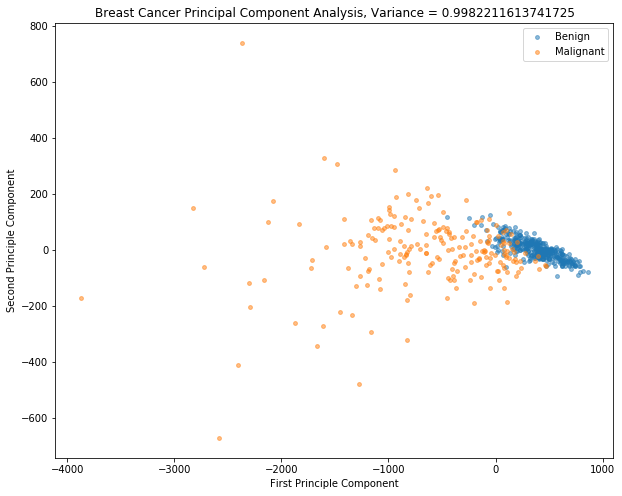

In [3]:
part1()

## Part 2
Creating the function similar(), which takes in a matrix representing documents and an index of a particular document, then returns the indices of the most and least similar documents to that one.

In [4]:
def similar(i, Xhat):
    """
    Takes an index and matrix representing principal components and returns the indices of
    the documents that are the most and least similar to i.
    
    Parameters:
    i index of a document
    Xhat decomposed data
    
    Returns:
    index_min: index of the document most similar to document i
    index_max: index of the document least similar to document i
    """
    #init list to hold vals (which will be sorted)
    vals = []
    
    #for each row of Xhat
    for j in range(Xhat.shape[0]):
        #calculate the similarity val and append
        val = np.dot(Xhat[i],Xhat[j])/(la.norm(Xhat[i])*la.norm(Xhat[j]))
        vals.append(val)
    
    #get second greatest and the least similar (a paper is most similar with itself, so avoid that)
    return np.argsort(vals)[-2], np.argmin(vals)

### Document Converter function - See doc string

In [5]:
def document_converter():
    '''
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents
    
    Returns:
    X sparse matrix (n x m): Each row represents a document
    paths (list): list where each element is a speech path eg: path[0] is './Addresses/1990-Bush.txt'
    '''
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = [folder+p for p in os.listdir(folder) if p.endswith(".txt")]

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r', encoding="utf8") as infile:
            for line in infile:
                vocab.update(extractWords(line)) #union sets together


    # load stopwords
    with open("stopwords.txt", 'r',  encoding="utf8") as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}


    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Iterate through the documents.
    for doc, p in enumerate(paths):
        with open(p, 'r', encoding="utf8") as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, store counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_index.append(vocab[word])
                    counts.append(count)
                    doc_index.append(doc)

    # Create sparse matrix holding these word counts.
    X = sparse.csr_matrix((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=np.float)
    return X, paths

## Part 3
Using document_converter and PCA to find speeches most and least similar to a given speech.

In [6]:
def part3(speech, l=7):
    """
    Uses LSI, applied to the word count matrix X, with the first 7 principal
    components to find the most similar and least similar speeches

    Parameters:
        speech str: Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """    
    #get sparse matrix of documents and the list of paths from the given function above
    X, paths = document_converter()
    
    #get svd
    U,E,Vh = sparse.linalg.svds(X,l)
    #form Xhat from PCA
    Xhat = X@Vh.T[:,:l]
    
    #find index of speech
    ind = paths.index(speech)
    
    #get most similar and least similar indices
    maxInd, minInd = similar(ind,Xhat)
    
    #return speech names at these indices
    return paths[maxInd][12:-4], paths[minInd][12:-4]

In [7]:
#Run this box once you have written part3()
speech = './Addresses/1984-Reagan.txt'
print(part3(speech))

speech = "./Addresses/1993-Clinton.txt"
print(part3(speech))

('1988-Reagan', '1946-Truman')
('2010-Obama', '1951-Truman')


### Altering document_converter to now place greater weight on more important words

In [8]:
def weighted_document_converter():
    '''
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents. It gives weights
    to the most important words in the vocabulary.
    
    Returns:
    A (sparse matrix, n x m): Each row represents a document
    paths (list): list where each element is a speech path eg: path[0] is './Addresses/1990-Bush.txt'
    '''
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = [folder+p for p in os.listdir(folder) if p.endswith(".txt")]

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r', encoding="utf8") as infile:
            for line in infile:
                vocab.update(extractWords(line)) #union sets together


    # load stopwords
    with open("stopwords.txt", 'r',  encoding="utf8") as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}

    t = np.zeros(len(vocab))
    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Iterate through the documents.
    for doc, p in enumerate(paths):
        with open(p, 'r', encoding="utf8") as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, store counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_ind = vocab[word]
                    word_index.append(word_ind)
                    counts.append(count)
                    doc_index.append(doc)
                    t[word_ind] += count
                    
    X = sparse.csr_matrix((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=np.float)
    #create p, m, n, and init g
    p = X/np.sum(X,axis=1)
    m, n = X.shape
    g = np.zeros(n)
    
    #populate g
    for j in range(n):
           g[j] = 1 + sum([p[i,j]*np.log(p[i,j]+1) for i in range(m)])/np.log(m)
            
    #init A
    A = np.zeros(X.shape)
    
    #fill in the A matrix
    for i in range(m):
        for j in range(n):
            A[i,j] = g[j]*np.log(X[i,j] + 1)
    
    #make A sparse, return it and paths
    return sparse.csr_matrix(A), paths

## Part 5
Using the weighted_document_converter function and scikit-learn's PCA to find speeches most and least similar to a given speech.

In [9]:
def part5(speech, l=7):
    """
    Uses LSI, applied to the globally weighted word count matrix A, with the
    first 7 principal components to find the most similar and least similar speeches

    Parameters:
        speech str: Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """
    #get sparse matrix of documents and the list of paths from the given function above, turn A no longer sparse
    X, paths = weighted_document_converter()
    X = X.toarray()
    
    #use sklearn's pca; fit to get xhat
    pca = PCA(n_components=l,svd_solver='full') # Create the PCA transformer with hyperparameters
    Xhat = pca.fit_transform(X) # Fit the transformer and transform the data
    
    #find index of speech
    ind = paths.index(speech)
    
    #get most similar and least similar indices
    maxInd, minInd = similar(ind,Xhat)
    
    #return speech names at these indices
    return paths[maxInd][12:-4], paths[minInd][12:-4]

In [10]:
#Run this box after you have completed part5()
speech = './Addresses/1984-Reagan.txt'
print(part5(speech))

speech = "./Addresses/1993-Clinton.txt"
print(part5(speech))

('1985-Reagan', '1961-Kennedy')
('1994-Clinton', '1951-Truman')


## Part 6
- Split the breast cancer dataset into training and testing sets using random_state=2
- Fit KNeighborsClassifier and RandomForestClassifier to the training data
- Predict labels for the testing set
- Print a classification_report for each classifier

In [11]:
#load cancer set
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target # Class labels (0 or 1)

#split them
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=2)

# Fit the esimator to training data and predict the test labels.
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)

#fit for random forest
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
forest_predicted = forest.predict(X_test)

#print best params
print(classification_report(y_test, knn_predicted))
print(classification_report(y_test, forest_predicted))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88        56
           1       0.94      0.90      0.92        87

    accuracy                           0.90       143
   macro avg       0.89      0.90      0.90       143
weighted avg       0.90      0.90      0.90       143

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        56
           1       0.95      0.95      0.95        87

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143



The forest is better because all the scores are higher. This is likely because these cancers aren't dependent on their locality to each other, so kneighbors won't do well classifying.

## Part 7
- Use the breast cancer dataset split from part 6
- Run a GridSearch with a RandomForestClassifier, modifying at least three parameters.
- Use scoring="f1"
- Print out best_params_ and best_score_
- Print a confusion matrix for the test data

In [12]:
forest = RandomForestClassifier()
# Specify values for certain hyperparameters
param_grid = {"n_estimators": [100,200,300,400,500,600],"criterion": ["gini", "entropy"],"min_samples_split":[2,3,4]}
forest_gs = GridSearchCV(forest, param_grid, scoring="f1", n_jobs=-1)
# Run the actual search. This may take some time.
forest_gs.fit(X_train, y_train)
# After fitting, you can access data about the results.
print(forest_gs.best_params_, forest_gs.best_score_, sep='\n')

# Access the model
forest_gs.best_estimator_


{'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 300}
0.9725018386174694


RandomForestClassifier(criterion='entropy', n_estimators=300)

In [13]:
best_forest = RandomForestClassifier(n_estimators=100,criterion='entropy',min_samples_split=3)
best_forest.fit(X_train, y_train)
confusion_matrix(y_test,best_forest.predict(X_test))

array([[52,  4],
       [ 4, 83]])

## Part 8
- Create a pipeline with a StandardScaler, PCA, and a KNeighborsClassifier
- Do a grid search

In [14]:
#create a pipeline now with pca in the middle
pipe = Pipeline([("scaler", StandardScaler()),("pca",PCA()),("knn",KNeighborsClassifier())])

#make a parameter grid with 6 total params; 2 each
pipe_param_grid = {"scaler__with_mean": [True, False],"scaler__with_std": [True, False],
                   "pca__n_components":[5,10,None,'mle'],"pca__whiten":[True,False], 
                   "knn__n_neighbors": [2,3,4,5,6],"knn__weights": ["uniform", "distance"]}

#find best
pipe_gs = GridSearchCV(pipe, pipe_param_grid, n_jobs=-1).fit(X_train, y_train)

In [15]:
#print those sexy parameters
print(pipe_gs.best_params_, pipe_gs.best_score_, sep='\n')

{'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'pca__n_components': 10, 'pca__whiten': False, 'scaler__with_mean': True, 'scaler__with_std': True}
0.9718467852257182
